# Springboard Regression Case Study - The Red Wine Dataset - Tier 3

# Project Overview

This will start with data wrangling and exploratory data analysis to visually observe of the effectiveness of each element on the temperature-dependent mechanical properties.For this we obtain the data from the following link: https://www.kaggle.com/code/eladariel/comparison-between-tensorflow-and-scikit-learn/data


# Data Wrangling

### 1. Sourcing and loading

#### 1a. Import relevant libraries 

In [7]:
# Import relevant libraries and packages.
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns # For all our visualization needs.
import statsmodels.api as sm # Second library for linear regression model based on OLS
from statsmodels.graphics.api import abline_plot # What does this do? Find out and type here.
from sklearn.metrics import mean_squared_error, r2_score # acess performance.
from sklearn.model_selection import train_test_split,cross_validate,KFold,cross_val_score #split data in training and testing dataset
from sklearn import linear_model, preprocessing # linear regression models
import warnings # For handling error messages.
# Don't worry about the following two instructions: they just suppress warnings that could occur later. 
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

#### 1b. Load the data

In [8]:
# Load the data. 
df=pd.read_csv("PDAS_all-original.csv")

#### 1c. Exploring the data

In [9]:
# Check out its appearance. 
df.head(n=5)

,V,G,Mat_HB,Mat_KF,PDAS
0,0.01,10000000.0,2.020000e-14,2.570000e-13,2.470000e-06
1,0.02,10000000.0,2.020000e-14,2.570000e-13,2.160000e-06
2,0.03,10000000.0,2.020000e-14,2.570000e-13,1.080000e-06
3,0.04,10000000.0,2.020000e-14,2.570000e-13,9.260000e-07
4,0.05,10000000.0,2.020000e-14,2.570000e-13,8.100000e-07


In [10]:
# overview of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239 entries, 0 to 238
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V       239 non-null    float64
 1   G       239 non-null    float64
 2   Mat_HB  239 non-null    float64
 3   Mat_KF  239 non-null    float64
 4   PDAS    239 non-null    float64
dtypes: float64(5)
memory usage: 9.5 KB


Because I have already generated the data I know the data are all in correct format and all the rows have correct values.
However this shows all columns have correct data type. They also do not have a missing value

In [11]:
df.isna().any()

V         False
G         False
Mat_HB    False
Mat_KF    False
PDAS      False
dtype: bool

As expected, we do not have any NULL values

In [12]:
df.duplicated().any()

False

In [13]:
df['Mat_HB'].nunique()

7

The data set have overall data for 7 alloys. for each alloy the PDAS is calculated based on different values of V and G.

In [14]:
print(df["Mat_HB"].unique())

[2.02e-14 3.37e-14 3.51e-14 5.85e-15 2.30e-15 4.33e-15 5.11e-15]


In [15]:
# We need a new column showing the alloy name
# we know Mat_HB of 2.02e-14 3.37e-14 3.51e-14 5.85e-15 2.30e-15 4.33e-15 5.11e-15 belonds to Ti-3.4%Ni, Ti-7.1%Ni, Ti-10.6%Ni, 
# Mg-9 at% Al, Al-6 at%Cu, Al-8 at%Cu, and Al-10 at%Cu

conditions=[np.logical_and(df["Mat_HB"].gt(2.01e-14),df["Mat_HB"].lt(2.03e-14)),
            np.logical_and(df["Mat_HB"].gt(3.36e-14),df["Mat_HB"].lt(3.38e-14)),
            np.logical_and(df["Mat_HB"].gt(3.50e-14),df["Mat_HB"].lt(3.52e-14)),
            np.logical_and(df["Mat_HB"].gt(5.84e-15),df["Mat_HB"].lt(5.86e-15)),
            np.logical_and(df["Mat_HB"].gt(2.29e-15),df["Mat_HB"].lt(2.31e-15)),
            np.logical_and(df["Mat_HB"].gt(4.32e-15),df["Mat_HB"].lt(4.34e-15)),
            np.logical_and(df["Mat_HB"].gt(5.10e-15),df["Mat_HB"].lt(5.12e-15))]
outputs=["Ti-3.4 at% Ni","Ti-7.1 at% Ni","Ti-10.7 at% Ni","Mg- 9 at% Al","Al-6 at% Cu","Al-8 at% Cu","Al-10 at% Cu"]
df["Alloy"]=pd.Series(np.select(conditions,outputs,"alloy"))


In [16]:
# OUR equation will have the following format PDAS=A (V)^alpha (G)^beta (matprop)^gamma. To make this easier to change to
# a regression model, 
# we will first deside the dependent variable as PDAS and then We will take ln of all the columns and add it to a new column
#and move forward with that
df.head()

,V,G,Mat_HB,Mat_KF,PDAS,Alloy
0,0.01,10000000.0,2.020000e-14,2.570000e-13,2.470000e-06,Ti-3.4 at% Ni
1,0.02,10000000.0,2.020000e-14,2.570000e-13,2.160000e-06,Ti-3.4 at% Ni
2,0.03,10000000.0,2.020000e-14,2.570000e-13,1.080000e-06,Ti-3.4 at% Ni
3,0.04,10000000.0,2.020000e-14,2.570000e-13,9.260000e-07,Ti-3.4 at% Ni
4,0.05,10000000.0,2.020000e-14,2.570000e-13,8.100000e-07,Ti-3.4 at% Ni


In [17]:
# Get a basic statistical summary of the dependent variable 
#PDAS is our fixed dependent variable
df["PDAS"].describe()

count    2.390000e+02
mean     2.303619e-06
std      5.231414e-06
min      1.320000e-07
25%      4.035000e-07
50%      7.130000e-07
75%      1.395000e-06
max      4.196500e-05
Name: PDAS, dtype: float64

In [18]:
df["PDAS_ln"]=np.log(df["PDAS"])
df["V_ln"]=np.log(df["V"])
df["G_ln"]=np.log(df["G"])
df["Mat_HB_ln"]=np.log(df["Mat_HB"])
df["Mat_KF_ln"]=np.log(df["Mat_KF"])
df_ln=df.drop(["PDAS","V","G","Mat_HB","Mat_KF"],axis=1)

In [19]:
# Call the .corr() method on the wine dataset 
df_ln.corr(method='pearson')

,PDAS_ln,V_ln,G_ln,Mat_HB_ln,Mat_KF_ln
PDAS_ln,1.000000,-0.815174,-0.112970,0.570036,0.496155
V_ln,-0.815174,1.000000,-0.042332,-0.166988,-0.116204
G_ln,-0.112970,-0.042332,1.000000,0.104856,0.251790
Mat_HB_ln,0.570036,-0.166988,0.104856,1.000000,0.962060
Mat_KF_ln,0.496155,-0.116204,0.251790,0.962060,1.000000


# Exploratory Data Analysis

Now that we've chosen PDAS as our dependent variable for regression analysis, we can begin by plotting the pairwise relationships in the dataset, to check out how our variables relate to one another.
if we plot the pairwise relationshi for V,G,matprop_HB,matprop_KF we do not see any specific relationship, but plotting the logaritmic in base e it will have useful information

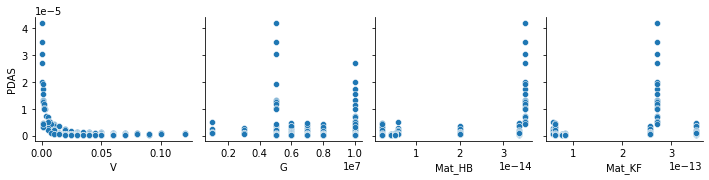

In [20]:
# Make a pairplot of the data just for PDAS
sns.pairplot(df,y_vars=["PDAS"],x_vars=["V","G","Mat_HB","Mat_KF"])

Visualization in this section helped us make sure we do not have any outliers in the PDAS data. However as said previously we need to checl the logaraithmic form of PDAS.
The results do not present a specific trend in for G , mat_HB, mat_Kf in comparison with the 

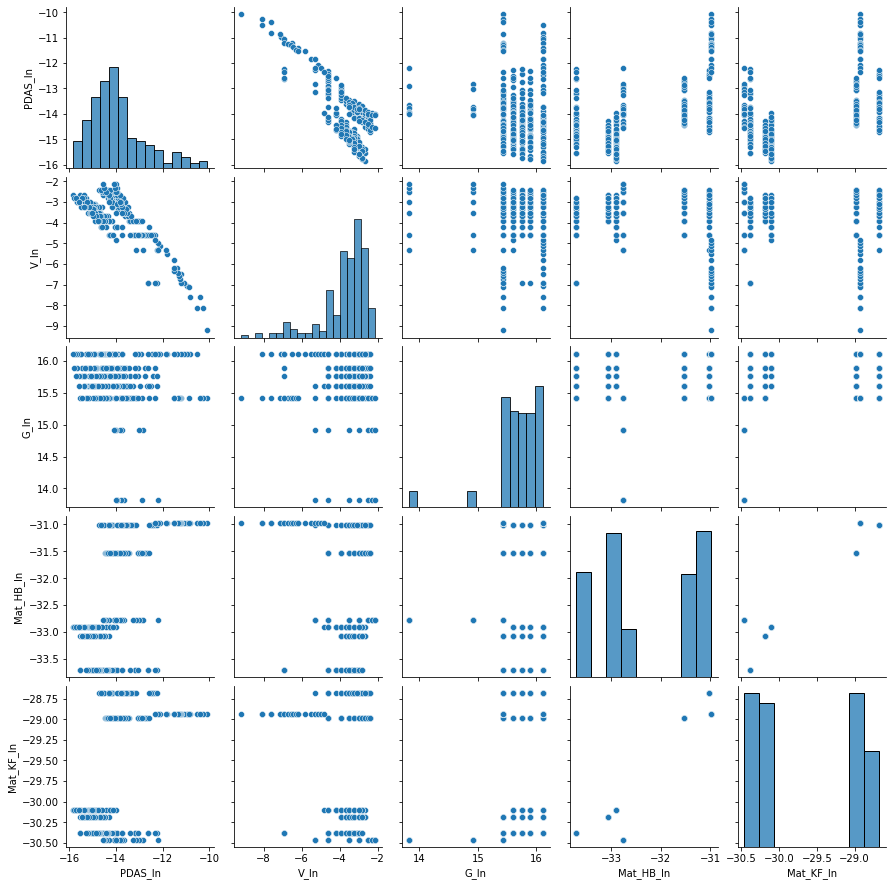

In [21]:
# Make a pairplot of the data
#sns.pairplot(df)
sns.pairplot(df_ln)

So we now have called the .corr() method, and the .pairplot() Seaborn method, on our data. Both have flaws. Happily, we can get the best of both worlds with a heatmap. 

<AxesSubplot:>

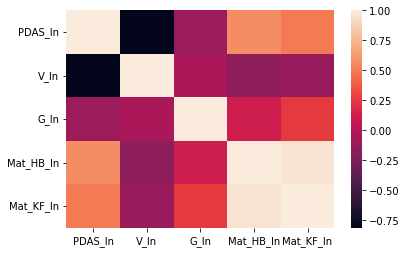

In [22]:
# Make a heatmap of the data 
sns.heatmap(df_ln.corr())

We find a strong correlation (negative) between PDAS_ln and V_ln, also PDAS_ln and G_ln. both HB and KF material properties also have strong but positive effects on PDAS_ln

In [23]:
color=sns.color_palette("husl", 7).as_hex()
print(color[0])

#f77189


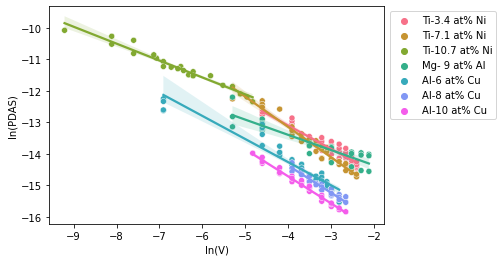

In [24]:
sns.scatterplot(data=df_ln,x="V_ln",y="PDAS_ln",hue="Alloy",palette=sns.color_palette("husl", 7)) #sizes=(20, 100),size="Mat_KF_ln",
sns.regplot(data=df_ln[df_ln["Alloy"]==outputs[0]],x="V_ln",y="PDAS_ln", scatter=False,line_kws={"color":color[0]}) #,line_kws={"color":"red"}
sns.regplot(data=df_ln[df_ln["Alloy"]==outputs[1]],x="V_ln",y="PDAS_ln", scatter=False,line_kws={"color":color[1]})
sns.regplot(data=df_ln[df_ln["Alloy"]==outputs[2]],x="V_ln",y="PDAS_ln", scatter=False,line_kws={"color":color[2]})
sns.regplot(data=df_ln[df_ln["Alloy"]==outputs[3]],x="V_ln",y="PDAS_ln", scatter=False,line_kws={"color":color[3]})
sns.regplot(data=df_ln[df_ln["Alloy"]==outputs[4]],x="V_ln",y="PDAS_ln", scatter=False,line_kws={"color":color[4]})
sns.regplot(data=df_ln[df_ln["Alloy"]==outputs[5]],x="V_ln",y="PDAS_ln", scatter=False,line_kws={"color":color[5]})
sns.regplot(data=df_ln[df_ln["Alloy"]==outputs[6]],x="V_ln",y="PDAS_ln", scatter=False,line_kws={"color":color[6]})
plt.xlabel("ln(V)")
plt.ylabel("ln(PDAS)")
plt.legend(bbox_to_anchor=(1.35 , 1), loc="upper right")

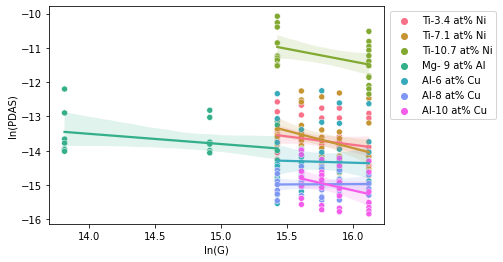

In [25]:
sns.scatterplot(data=df_ln,x="G_ln",y="PDAS_ln",hue="Alloy",palette=sns.color_palette("husl", 7)) #sizes=(20, 100),size="Mat_KF_ln",
sns.regplot(data=df_ln[df_ln["Alloy"]==outputs[0]],x="G_ln",y="PDAS_ln", scatter=False,line_kws={"color":color[0]}) #,line_kws={"color":"red"}
sns.regplot(data=df_ln[df_ln["Alloy"]==outputs[1]],x="G_ln",y="PDAS_ln", scatter=False,line_kws={"color":color[1]})
sns.regplot(data=df_ln[df_ln["Alloy"]==outputs[2]],x="G_ln",y="PDAS_ln", scatter=False,line_kws={"color":color[2]})
sns.regplot(data=df_ln[df_ln["Alloy"]==outputs[3]],x="G_ln",y="PDAS_ln", scatter=False,line_kws={"color":color[3]})
sns.regplot(data=df_ln[df_ln["Alloy"]==outputs[4]],x="G_ln",y="PDAS_ln", scatter=False,line_kws={"color":color[4]})
sns.regplot(data=df_ln[df_ln["Alloy"]==outputs[5]],x="G_ln",y="PDAS_ln", scatter=False,line_kws={"color":color[5]})
sns.regplot(data=df_ln[df_ln["Alloy"]==outputs[6]],x="G_ln",y="PDAS_ln", scatter=False,line_kws={"color":color[6]})
plt.xlabel("ln(G)")
plt.ylabel("ln(PDAS)")
plt.legend(bbox_to_anchor=(1.35 , 1), loc="upper right")

This shows we obtain a decending behavior between PDAS with both V and G , while it seems V have a stronger effect. This was also supported by the heatmap plot.

# Modeling 

## 3a. Making a Linear Regression mode based on all the data and HB model
### statmodels library 
First we will work on regression  model based on matprop_HP

In [26]:
# Create test and train datasets
# Include all columns from df_ln in the explanatory variables X except "PDAS_ln","Mat_KF_ln"
x=df_ln.drop(["PDAS_ln","Mat_KF_ln","Alloy"],axis=1)

# Create constants for X, so the model knows its bounds
x=sm.add_constant(x)
y=df[["PDAS_ln"]]

# Split the data
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25)

In [27]:
# We can use almost identical code to create the third model, because it is the same algorithm, just different inputs
# Create the model
rModel_HB= sm.OLS(y_train,x_train)

# Fit the model
results_HB = rModel_HB.fit()

In [28]:
# Evaluate the model
results_HB.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                PDAS_ln   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     472.6
Date:                Wed, 04 Jan 2023   Prob (F-statistic):           1.19e-83
Time:                        18:42:37   Log-Likelihood:                -85.712
No. Observations:                 179   AIC:                             179.4
Df Residuals:                     175   BIC:                             192.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.4117      1.530      5.499      0.000       5.392      11.431
V_ln          -0.7053      0.024    -29.659      0.000      -0.752      -0.658
G_ln          -0.5398      0.070     -7.697      0.000      -0.678      -0.401
Mat_HB_ln      0.5117      0.029     17.702      0.000       0.455       0.569
==============================================================================
Omnibus:                        6.142   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.046   Jarque-Bera (JB):                3.221
Skew:                          -0.006   Prob(JB):                        0.200
Kurtosis:                       2.343   Cond. No.                     1.87e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.87e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [29]:
# Use our new model to make predictions
pedictions_HB=results_HB.predict(x_test)

<Figure size 576x576 with 0 Axes>

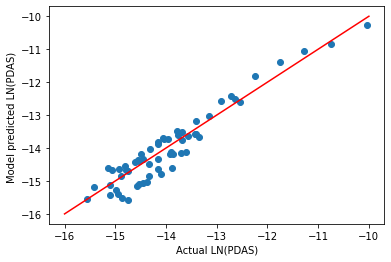

<Figure size 576x576 with 0 Axes>

In [30]:
# Plot the predictions
# Build a scatterplot
plt.scatter(pedictions_HB,y_test)
# Add a line for perfect correlation
plt.plot([-16,-10],[-16,-10],marker="None",color="red")

# Label it nicely
plt.xlabel("Actual LN(PDAS)")
plt.ylabel ("Model predicted LN(PDAS) ")

#plt.xlim([4,16])
#plt.ylim([4,16])

plt.figure(figsize=(8, 8))

In [31]:
RMSE_HB=mean_squared_error(y_test,pedictions_HB,squared="yes")
print(RMSE_HB)

0.12489522262958389


## sklearn library and cross validation

In [32]:
#R2 for one split does not represent the model's accuracy. For this, we will perform KFold cross validation

# we will perform 20 kfold with 10 splits
x=df_ln.drop(["PDAS_ln","Mat_KF_ln","Alloy"],axis=1)
y=df_ln[["PDAS_ln"]]

num_split=10
kf=KFold(n_splits=num_split, shuffle=True,random_state=42)
rModel_HB= linear_model.LinearRegression()
cv_result_HB=cross_validate(rModel_HB,x,y,cv=kf,return_estimator=True)
coeff=np.zeros((num_split,4))
i=0
for model in cv_result_HB['estimator']:
    coeff[i,0]=model.intercept_[0]
    coeff[i,1]=model.coef_[0,0]
    coeff[i,2]=model.coef_[0,1]
    coeff[i,3]=model.coef_[0,2]
    i+=1
#    print(model.coef_)
#    print(model.intercept_)

print("the mean ln(intercept) coeff is {}, with stdev of {} and 95%CI of {}".format(np.mean(coeff[:,0]),np.std(coeff[:,0]),np.quantile(coeff[:,0],[0.025,0.975])))
print("the mean ln(V) coeff is {}, with stdev of {} and 95%CI of {}".format(np.mean(coeff[:,1]),np.std(coeff[:,1]),np.quantile(coeff[:,1],[0.025,0.975])))
print("the mean ln(G) coeff is {}, with stdev of {} and 95%CI of {}".format(np.mean(coeff[:,2]),np.std(coeff[:,2]),np.quantile(coeff[:,2],[0.025,0.975])))
print("the mean ln(matprop_HB) coeff is {}, with stdev of {} and 95%CI of {}".format(np.mean(coeff[:,3]),np.std(coeff[:,3]),np.quantile(coeff[:,3],[0.025,0.975])))
cv_results_HB = cross_val_score(rModel_HB, x,y, cv=kf)
print("the mean r2 coeff is {}, with stdev of {} and 95%CI of {}".format(np.mean(cv_results_HB),np.std(cv_results_HB),np.quantile(cv_results_HB,[0.025,0.975])))


the mean ln(intercept) coeff is 8.694161411177102, with stdev of 0.3206778234242968 and 95%CI of [8.26837906 9.15552917]
the mean ln(V) coeff is -0.7068036130331459, with stdev of 0.007496931634744527 and 95%CI of [-0.72276889 -0.69921802]
the mean ln(G) coeff is -0.5301243557879523, with stdev of 0.011673394911467084 and 95%CI of [-0.55004265 -0.51068256]
the mean ln(matprop_HB) coeff is 0.525735682321842, with stdev of 0.006711106004523612 and 95%CI of [0.51498905 0.53530229]
the mean r2 coeff is 0.8598240913060302, with stdev of 0.08151425437020031 and 95%CI of [0.70571783 0.92901727]


#### 3b. Making a Linear Regression mode based on all the data and KF model
First we will work on regression  model based on matprop_KF

## statmodels library

In [33]:
# Create test and train datasets
# Include all columns from df_ln in the explanatory variables X except "PDAS_ln","Mat_HB_ln"
x=df_ln.drop(["PDAS_ln","Mat_HB_ln", "Alloy"],axis=1)

# Create constants for X, so the model knows its bounds
x=sm.add_constant(x)
y=df[["PDAS_ln"]]

# Split the data
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25)

In [34]:
# We can use almost identical code to create the third model, because it is the same algorithm, just different inputs
# Create the model
rModel_KF= sm.OLS(y_train,x_train)

# Fit the model
results_KF = rModel_KF.fit()

In [35]:
# Evaluate the model
results_KF.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                PDAS_ln   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     563.9
Date:                Wed, 04 Jan 2023   Prob (F-statistic):           1.13e-89
Time:                        18:42:47   Log-Likelihood:                -74.648
No. Observations:                 179   AIC:                             157.3
Df Residuals:                     175   BIC:                             170.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.5745      1.889      9.303      0.000      13.846      21.303
V_ln          -0.7359      0.022    -33.754      0.000      -0.779      -0.693
G_ln          -0.6978      0.081     -8.598      0.000      -0.858      -0.538
Mat_KF_ln      0.7881      0.040     19.941      0.000       0.710       0.866
==============================================================================
Omnibus:                        2.763   Durbin-Watson:                   2.136
Prob(Omnibus):                  0.251   Jarque-Bera (JB):                2.543
Skew:                           0.212   Prob(JB):                        0.280
Kurtosis:                       2.598   Cond. No.                     2.30e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.3e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [36]:
# Use our new model to make predictions
pedictions_KF=results_KF.predict(x_test)

<Figure size 576x576 with 0 Axes>

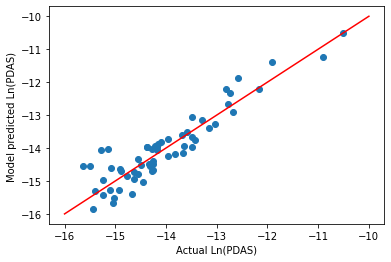

<Figure size 576x576 with 0 Axes>

In [37]:
# Plot the predictions
# Build a scatterplot
plt.scatter(pedictions_KF,y_test)
# Add a line for perfect correlation
plt.plot([-16,-10],[-16,-10],marker="None",color="red")

# Label it nicely
plt.xlabel("Actual Ln(PDAS)")
plt.ylabel ("Model predicted Ln(PDAS) ")

#plt.xlim([4,16])
#plt.ylim([4,16])

plt.figure(figsize=(8, 8))

In [38]:
RMSE_KF=mean_squared_error(y_test,pedictions_KF,squared="yes")
print(RMSE_KF)

0.187121490369253


## sklearn library and cross validation

In [39]:
#R2 for one split does not represent the model's accuracy. For this, we will perform KFold cross validation

# we will perform 20 kfold with 10 splits
x=df_ln.drop(["PDAS_ln","Mat_HB_ln","Alloy"],axis=1)
y=df_ln[["PDAS_ln"]]

num_split=10
kf=KFold(n_splits=num_split, shuffle=True,random_state=42)
rModel_KF= linear_model.LinearRegression()
cv_result_KF=cross_validate(rModel_KF,x,y,cv=kf,return_estimator=True)
coeff=np.zeros((num_split,4))
i=0
for model in cv_result_KF['estimator']:
    coeff[i,0]=model.intercept_[0]
    coeff[i,1]=model.coef_[0,0]
    coeff[i,2]=model.coef_[0,1]
    coeff[i,3]=model.coef_[0,2]
    i+=1
#    print(model.coef_)
#    print(model.intercept_)

print("the mean ln(intercept) coeff is {}, with stdev of {} and 95%CI of {}".format(np.mean(coeff[:,0]),np.std(coeff[:,0]),np.quantile(coeff[:,0],[0.025,0.975])))
print("the mean ln(V) coeff is {}, with stdev of {} and 95%CI of {}".format(np.mean(coeff[:,1]),np.std(coeff[:,1]),np.quantile(coeff[:,1],[0.025,0.975])))
print("the mean ln(G) coeff is {}, with stdev of {} and 95%CI of {}".format(np.mean(coeff[:,2]),np.std(coeff[:,2]),np.quantile(coeff[:,2],[0.025,0.975])))
print("the mean ln(matprop_KF) coeff is {}, with stdev of {} and 95%CI of {}".format(np.mean(coeff[:,3]),np.std(coeff[:,3]),np.quantile(coeff[:,3],[0.025,0.975])))
cv_results_KF = cross_val_score(rModel_KF, x,y, cv=kf)
print("the mean r2 coeff is {}, with stdev of {} and 95%CI of {}".format(np.mean(cv_results_KF),np.std(cv_results_KF),np.quantile(cv_results_KF,[0.025,0.975])))


the mean ln(intercept) coeff is 17.555014882955746, with stdev of 0.37262221671443563 and 95%CI of [17.0321646 18.0894659]
the mean ln(V) coeff is -0.7313023615100528, with stdev of 0.008190351868339678 and 95%CI of [-0.74879407 -0.72342683]
the mean ln(G) coeff is -0.725256809125373, with stdev of 0.015617821470373274 and 95%CI of [-0.75127527 -0.70033373]
the mean ln(matprop_KF) coeff is 0.7719751047651723, with stdev of 0.009883690725519118 and 95%CI of [0.75916918 0.78886246]
the mean r2 coeff is 0.8597315407744063, with stdev of 0.08109141482816842 and 95%CI of [0.69320155 0.93225066]


## 3b. Making a Linear Regression mode based on each alloy's data without focusing on any HB/KF model

Here we want to see if we just focus on one alloy at a time and eliminate the effect of material properties, can we obtain a consistant correlation between PDAS with V and G

## Ti- 3.4 at% Ni

In [40]:
#R2 for one split does not represent the model's accuracy. For this, we will perform KFold cross validation

# we will perform 20 kfold with 10 splits
for alloy in outputs:
    x=df_ln[df_ln["Alloy"]==alloy].drop(["PDAS_ln","Mat_HB_ln","Mat_KF_ln","Alloy"],axis=1)
    y=df_ln[df_ln["Alloy"]==alloy]["PDAS_ln"]

    num_split=10
    kf=KFold(n_splits=num_split, shuffle=True,random_state=42)
    rModel_KF= linear_model.LinearRegression()
    cv_result_KF=cross_validate(rModel_KF,x,y,cv=kf,return_estimator=True)
    coeff=np.zeros((num_split,3))
    i=0
    for model in cv_result_KF['estimator']:
        coeff[i,0]=model.intercept_
        coeff[i,1]=model.coef_[0]
        coeff[i,2]=model.coef_[1]
        i+=1


    print("for {} alloy, the mean ln(intercept) coeff is {}, with stdev of {} and 95%CI of {}".format(alloy,round(np.mean(coeff[:,0]),2),round(np.std(coeff[:,0]),2),np.quantile(coeff[:,0],[0.025,0.975])))
    print("for {} alloy, the mean ln(V) coeff is {}, with stdev of {} and 95%CI of {}".format(alloy,round(np.mean(coeff[:,1]),2),round(np.std(coeff[:,1]),2),np.quantile(coeff[:,1],[0.025,0.975])))
    print("for {} alloy, the mean ln(G) coeff is {}, with stdev of {} and 95%CI of {}".format(alloy,round(np.mean(coeff[:,2]),2),round(np.std(coeff[:,2]),2),np.quantile(coeff[:,2],[0.025,0.975])))
    print("for {} alloy, the mean r2 coeff is {}, with stdev of {} and 95%CI of {}".format(alloy,round(np.mean(cv_results_KF),2),round(np.std(cv_results_KF),2),np.quantile(cv_results_KF,[0.025,0.975])))

for Ti-3.4 at% Ni alloy, the mean ln(intercept) coeff is -8.33, with stdev of 0.34 and 95%CI of [-8.8438962  -7.93918423]
for Ti-3.4 at% Ni alloy, the mean ln(V) coeff is -0.75, with stdev of 0.01 and 95%CI of [-0.75508883 -0.73336259]
for Ti-3.4 at% Ni alloy, the mean ln(G) coeff is -0.49, with stdev of 0.02 and 95%CI of [-0.51548369 -0.46091846]
for Ti-3.4 at% Ni alloy, the mean r2 coeff is 0.86, with stdev of 0.08 and 95%CI of [0.69320155 0.93225066]
for Ti-7.1 at% Ni alloy, the mean ln(intercept) coeff is -13.03, with stdev of 0.48 and 95%CI of [-13.70399766 -12.10692832]
for Ti-7.1 at% Ni alloy, the mean ln(V) coeff is -0.94, with stdev of 0.01 and 95%CI of [-0.95850062 -0.91916794]
for Ti-7.1 at% Ni alloy, the mean ln(G) coeff is -0.25, with stdev of 0.03 and 95%CI of [-0.30097793 -0.20289951]
for Ti-7.1 at% Ni alloy, the mean r2 coeff is 0.86, with stdev of 0.08 and 95%CI of [0.69320155 0.93225066]
for Ti-10.7 at% Ni alloy, the mean ln(intercept) coeff is -14.94, with stdev of 0

### Conclusions & next steps

Fitting the PDAS to HB and KF models suggests thatthe best fit of phase-field PDAS to 
